# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [143]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [144]:
print(y.mean())

0.4995


In [145]:
from sklearn.svm import SVC

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit
from sklearn.pipeline import Pipeline


In [147]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [148]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = \
        precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=False)

In [150]:
grid = GridSearchCV(LinearSVC(max_iter=1000000, tol=1e-2), param_grid={'C': np.logspace(-3, 1, 10)}, cv = 5,
                    scoring=pr_auc_scorer)


In [151]:
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.01, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(pr_auc_score), verbose=0)

In [152]:
grid.fit(X_train, y_train)
best_C = grid.best_params_['C']
print("Best C = %.4f" % best_C)

Best C = 0.0010


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [153]:
svc = LinearSVC(max_iter=100000, C=best_C).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC AUC-PR: %.5f' % pr_auc_score(y_test, svc_pred))
print('SVC ROC-AUC: %.5f' %roc_auc_score(y_test, svc_pred))

SVC AUC-PR: 0.83058
SVC ROC-AUC: 0.84718


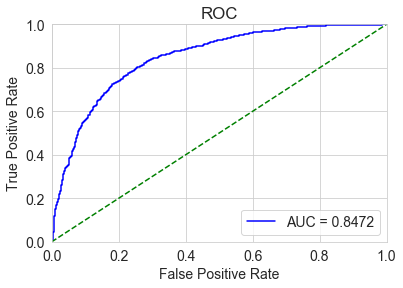

In [154]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test, svc_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


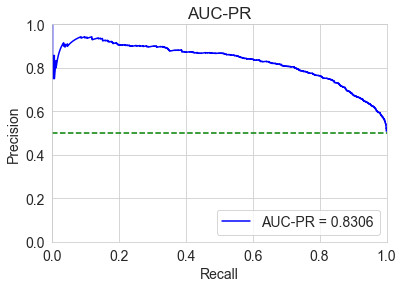

In [155]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, svc_pred)
auc_pr = metrics.auc(recall, precision)


plt.title('AUC-PR')
plt.plot(recall, precision, 'b', label = 'AUC-PR = %0.4f' % auc_pr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [156]:
grid_lr = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=100000, tol=1e-2), param_grid={'C': np.logspace(-2, 1, 20)}, cv = 5,
                    scoring=pr_auc_scorer)


In [157]:
grid_lr.fit(X_train, y_train)
best_C_lr = grid_lr.best_params_['C']
print("Best C_lr = %.4f" % best_C_lr)

Best C_lr = 0.2637


In [158]:
lr = LogisticRegression(max_iter=100000, C=best_C_lr, solver='lbfgs').fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
print('Logistic regression AUC-PR: %.5f' % pr_auc_score(y_test, lr_pred))
print('Logistic regression ROC-AUC: %.5f' %roc_auc_score(y_test, lr_pred))

Logistic regression AUC-PR: 0.82914
Logistic regression ROC-AUC: 0.84785


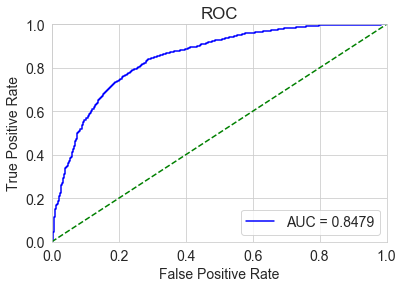

In [159]:
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

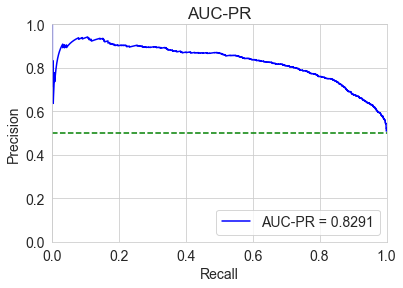

In [160]:
precision, recall, thresholds = precision_recall_curve(y_test, lr_pred)
auc_pr = metrics.auc(recall, precision)

plt.title('AUC-PR')
plt.plot(recall, precision, 'b', label = 'AUC-PR = %0.4f' % auc_pr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [161]:
X_, y_ = make_classification(n_samples=50, n_features=2, random_state=0, n_redundant = 0)

In [162]:
model = SVC(kernel='linear')
model.fit(X_, y_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

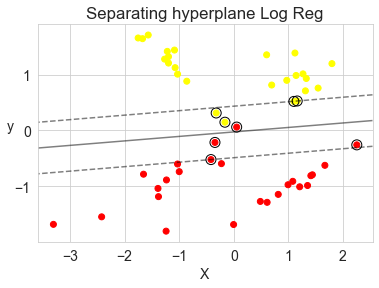

In [163]:
ax = plt.gca()
plt.scatter(X_[:,0], X_[:,1], c = y_, cmap='autumn')


xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,

           linewidth=1, facecolors='none', edgecolors='k')
ax.set_title('Separating hyperplane Log Reg')
ax.set_xlabel('X')
ax.set_ylabel('y', rotation = 360)

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [164]:
lr2 = LogisticRegression(solver = 'lbfgs', max_iter=100000).fit(X_, y_)
lr2_pred = lr2.decision_function(X_)
lr2_pred

array([ 3.68355617, -5.03715175,  1.30049217, -1.87590774,  2.56751438,
       -0.83174997,  2.42632811,  2.19111588,  3.65861444,  2.53451242,
        1.95954356, -2.31197854, -2.96353084, -1.93254605, -3.57135218,
       -5.28090655,  4.30014279,  1.81151946,  3.39746485, -2.89362042,
       -4.89534807,  4.45570149, -2.46863349, -3.35948775,  3.18689991,
        3.56976155,  0.18423819, -1.87863618, -3.72469356,  3.07759579,
        2.07171058, -2.87148258,  0.6353827 , -3.163611  , -2.73535036,
        2.85563066, -2.35724684,  3.27074204, -1.6848496 ,  1.27591424,
        2.31833125,  3.72916599, -2.69786962,  2.65253106, -0.04764633,
       -3.763701  , -4.6231374 , -0.82940654,  4.2694009 , -2.40288307])

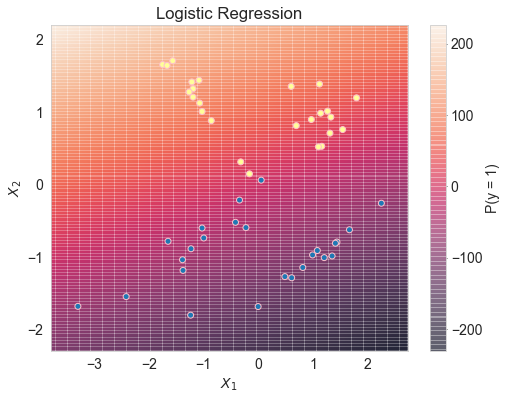

In [165]:
f, ax = plt.subplots(figsize=(8, 6))

logreg = LogisticRegression(C=1e5,solver='lbfgs')
logreg.fit(X_, y_)

x_min, x_max = X_[:, 0].min() - 0.5, X_[:, 0].max() + 0.5
y_min, y_max = X_[:, 1].min() - 0.5, X_[:, 1].max() + 0.5
h = 0.02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
graph = ax.pcolor(xx, yy, Z, alpha = 0.4)
ax.set(xlim=(xx.min(), xx.max()), ylim=(yy.min(), yy.max()),
       xlabel="$X_1$", ylabel="$X_2$", title = 'Logistic Regression')
ax_c = f.colorbar(graph)
ax_c.set_label("P(y = 1)")

ax_c.ax.tick_params(length = 1)
#ax_c.ax.yaxis.set_ticks([1, 2, 3], minor=True)
ax.scatter(X_[:, 0], X_[:, 1], c=y_, edgecolors="k", cmap=plt.cm.Paired, vmin=-.2, vmax=1.2, edgecolor="pink", linewidth=1)
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [166]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2) 
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

In [167]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1)/(y_test[(preds >= l) & (preds < r)].size)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [168]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [169]:
X_test

array([[-0.42254394, -0.55830354,  1.29161232, ..., -3.42421283,
         0.6405143 ,  0.83272736],
       [-2.05830274, -5.22087431,  1.30545504, ...,  2.98498342,
         4.83276657, -0.72073202],
       [ 0.5072411 , -2.42547815,  1.67703688, ...,  1.75838788,
         2.97596395, -0.63890401],
       ...,
       [-0.10222285, -4.353089  ,  3.11928353, ...,  2.46030904,
         4.81010498, -1.05638972],
       [ 0.29191017,  0.62736831,  0.49553516, ..., -2.18872512,
        -1.55223637,  0.1434533 ],
       [ 1.62812226,  3.00256674, -1.45886668, ...,  0.15108645,
        -2.59795758,  0.05484047]])

In [170]:

pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear'))
])
model_hey = pipeline.fit(X_train, y_train)
lr_pred = model_hey.decision_function(X_test)
lr_pred_proba = model_hey.predict_proba(X_test)[:, 1]


Text(0.5, 1.0, 'Logistic regression calibration curve')

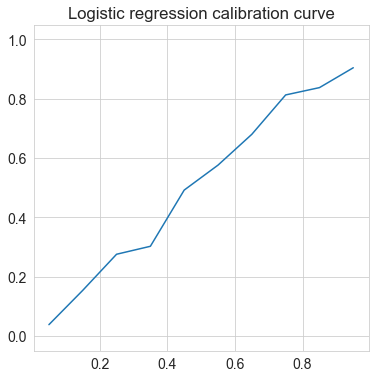

In [171]:
plot_calibration_curve(y_test, lr_pred_proba)
plt.grid()
plt.title('Logistic regression calibration curve')

In [172]:
lr_pred

array([ 0.88876989, -4.37373603, -1.52179873, ..., -2.75339124,
        1.85542931,  2.56327129])

In [173]:
pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('classifier', LinearSVC(max_iter=100000))
])
model = pipeline.fit(X_train, y_train)
svm_pred = model.decision_function(X_test)

In [174]:
svm_pred = (svm_pred - svm_pred.min()) / (svm_pred.max() - svm_pred.min())

Text(0.5, 1.0, 'SVM calibration curve')

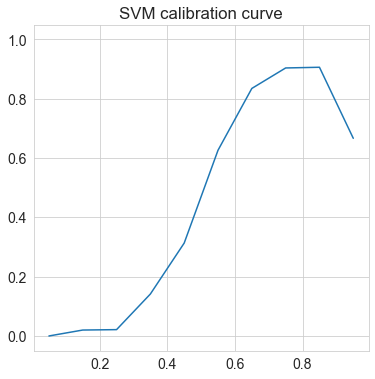

In [175]:
plot_calibration_curve(y_test, svm_pred)
plt.grid()
plt.title('SVM calibration curve')

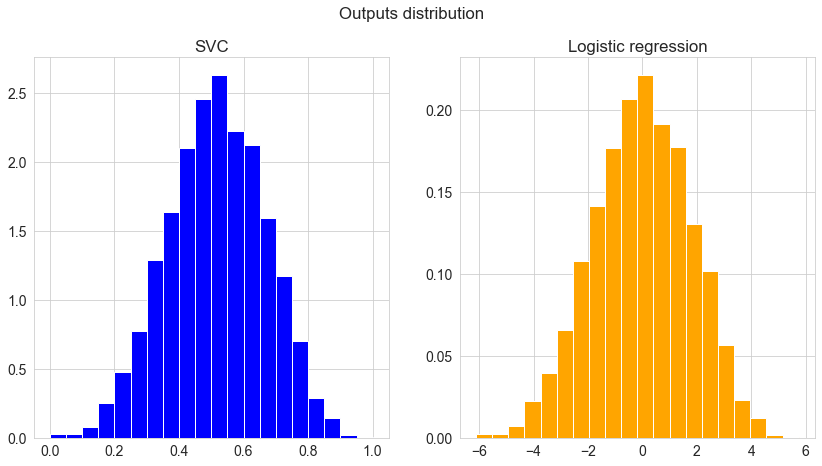

In [176]:
ig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svm_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()


Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [177]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3).fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8473790633552487


Text(0.5, 1.0, 'SVM calibration curve after CalibratedClassifierCV')

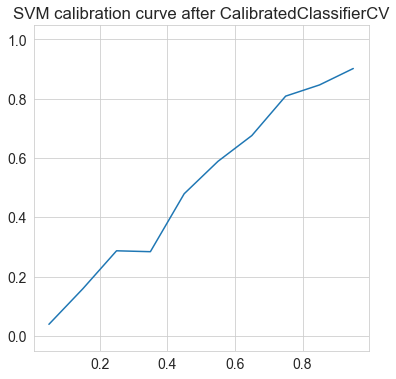

In [178]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.grid()
plt.title('SVM calibration curve after CalibratedClassifierCV')

In [179]:
sigmoid_svc_pred

array([0.69088832, 0.01336613, 0.18333051, ..., 0.06278669, 0.85080264,
       0.92549162])

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [180]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [181]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [182]:
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [183]:
df = df.drop("duration", axis=1)

In [184]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [185]:
df.y=df.y.replace(({'no': 0, 'yes': 1}))
df.contact=df.contact.replace(({'cellular': 0, 'telephone': 1}))

In [186]:
df_X = df.drop('y', axis=1)
df_y = df['y']

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=777, stratify = df_y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: AUC PR лучше отражает качество предсказаний относительно положительного класса, тогда как AUC-ROC учитывает FPR. Нам больше интересен положительный класс, так как цель  - предсказать вероятность того, что клиент все-таки возьмет кредит

In [188]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,1,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,1,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,1,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,1,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,1,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,0,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,0,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,0,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,0,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [189]:
numeric = df.drop('y', axis = 1).select_dtypes(include=np.number).columns.tolist()
numeric.remove('contact')
categorical = df.select_dtypes(include=object).columns.tolist()

In [190]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('encoding', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding_and_scaling', column_transformer),
    ('regression', LogisticRegression(solver = 'lbfgs', max_iter=100000))
])

model_ordinal_encoder = pipeline.fit(X_train, y_train)
%timeit model_ordinal_encoder = pipeline.fit(X_train, y_train)
print('Logistic Regression PR-AUC OrdinalEncoder on train data: %.9f' %pr_auc_score(y_train, model_ordinal_encoder.decision_function(X_train)))
print('Logistic Regression PR-AUC OrdinalEncoder on test data: %.9f' %pr_auc_score(y_test, model_ordinal_encoder.decision_function(X_test)))

1.59 s ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Logistic Regression PR-AUC OrdinalEncoder on train data: 0.432869486
Logistic Regression PR-AUC OrdinalEncoder on test data: 0.433532153


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [191]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding_and_scaling', column_transformer),
    ('regression', LogisticRegression(solver = 'lbfgs', max_iter=100000))
])

model_ohe = pipeline.fit(X_train, y_train)
%timeit model_ohe = pipeline.fit(X_train, y_train)

print('Logistic Regression PR-AUC OneHotEncoder on train data: %.9f' %pr_auc_score(y_train, model_ohe.decision_function(X_train)))
print('Logistic Regression PR-AUC OneHotEncoder on test data: %.9f' %pr_auc_score(y_test, model_ohe.decision_function(X_test)))

5.1 s ± 499 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Logistic Regression PR-AUC OneHotEncoder on train data: 0.448465279
Logistic Regression PR-AUC OneHotEncoder on test data: 0.443414477


Качество стало хуже и выполняется в разы дольше.

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [192]:
#pip install --upgrade category_encoders

In [193]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.ordinal import OrdinalEncoder
import category_encoders.utils as util

In [194]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    

    def __init__(self, categorical_list=None, smoothing=0):
        self.categorical_list = categorical_list
        self.smoothing = smoothing
        self._dim = None
        self.mapping = None
        #self.handle_unknown = handle_unknown
        self._mean = None
        self.united_df = None
        

    def fit(self, X, y, **kwargs):
     
        self.united_df = pd.concat([X, y], axis = 1)
        self.dim = X.shape[1]


        if self.categorical_list is None:
            self.categorical_list = X.columns.tolist()
        self.mapping = self.fit_target_encoding(X, y)
        
        return self

    def fit_target_encoding(self, X, y):
        mapping = {}
        
        for cat in self.categorical_list:
            prior = y.mean()
            self._mean = y.mean()
            n = self.united_df.groupby(cat).size()
            val_mean = self.united_df.groupby(cat).mean().iloc[:, -1]
            smoothed = (n * val_mean + self.smoothing * prior) / (n + self.smoothing)
            smoothed[n == 1] = prior
            
            mapping[cat] = smoothed
        return mapping

    def transform(self, X, y=None, override_return_df=False):
        X = self.target_encode(X)
        return X
        

    def target_encode(self, X_in):
        X = X_in.copy(deep=True)
        ni = 0

        for col in self.categorical_list:
            X[col] = X[col].map(self.mapping[col])
            X[col] = X[col].fillna(float(self._mean))
        return X


In [195]:
X_train_mt = X_train.copy()
X_test_mt = X_test.copy()

In [196]:
mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
%timeit mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
X_train_mt = mte.transform(X_train)
X_test_mt = mte.transform(X_test)
sc = StandardScaler().fit(X_train[numeric])
X_train_mt[numeric] = sc.transform(X_train[numeric])
X_test_mt[numeric] = sc.transform(X_test[numeric])
lg = LogisticRegression(solver = 'lbfgs', max_iter=1000).fit(X_train_mt, y_train)
print('Logistic Regression PR-AUC mean-target encoding on train data: %.9f' %pr_auc_score(y_train, lg.decision_function(X_train_mt)))
auc_mt = pr_auc_score(y_test, lg.decision_function(X_test_mt))
print('Logistic Regression PR-AUC mean-target encoding on test data: %.9f' %auc_mt)

180 ms ± 7.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Logistic Regression PR-AUC mean-target encoding on train data: 0.440055181
Logistic Regression PR-AUC mean-target encoding on test data: 0.442006778


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [197]:
X_train_mt = X_train.copy()
X_test_mt = X_test.copy()

In [198]:
mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
%timeit mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
X_train_mt = mte.transform(X_train) 
X_train_mt[categorical] += 1e-2 * np.random.randn(X_train[categorical].shape[0], X_train[categorical].shape[1])
X_test_mt = mte.transform(X_test)
sc = StandardScaler().fit(X_train[numeric])
X_train_mt[numeric] = sc.transform(X_train[numeric])
X_test_mt[numeric] = sc.transform(X_test[numeric])
 
lg = LogisticRegression(solver = 'lbfgs', max_iter=1000).fit(X_train_mt, y_train)
print('Logistic Regression PR-AUC mean-target encoding with noise on train data: %.9f' %pr_auc_score(y_train, lg.decision_function(X_train_mt)))
auc_mt = pr_auc_score(y_test, lg.decision_function(X_test_mt))
print('Logistic Regression PR-AUC mean-target encoding with noise on test data: %.9f' %auc_mt)

151 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Logistic Regression PR-AUC mean-target encoding with noise on train data: 0.439369159
Logistic Regression PR-AUC mean-target encoding with noise on test data: 0.442428635


Качество стало лучше на 4 тысячных.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [199]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [200]:
categorical = ['job', 'marital', 'education','default', 'housing', 'loan','month','day_of_week','poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [201]:
X_train_mt = X_train.copy()
X_test_mt = X_test.copy()

In [202]:
mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
%timeit mte = MeanTargetEncoder(categorical_list= categorical, smoothing=10).fit(X_train, y_train)
X_train_mt = mte.transform(X_train)
X_test_mt = mte.transform(X_test)
sc = StandardScaler().fit(X_train[numeric])
X_train_mt[numeric] = sc.transform(X_train[numeric])
X_test_mt[numeric] = sc.transform(X_test[numeric])
lg = LogisticRegression(solver = 'lbfgs', max_iter=1000).fit(X_train_mt, y_train)


print('Logistic Regression PR-AUC mean-target encoding on train data: %.9f' %pr_auc_score(y_train, lg.decision_function(X_train_mt)))
print('Logistic Regression PR-AUC mean-target encoding on test data: %.9f' %pr_auc_score(y_test, lg.decision_function(X_test_mt)))

137 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Logistic Regression PR-AUC mean-target encoding on train data: 0.440055181
Logistic Regression PR-AUC mean-target encoding on test data: 0.442006778


Качество стало лучше еще на 1 тысячную.

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [203]:
categorical.append('age')
numeric.remove('age')

In [204]:
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'month',
 'day_of_week',
 'poutcome',
 'age']

In [205]:
mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train, y_train)
%timeit mte = MeanTargetEncoder(categorical_list= categorical, smoothing=10).fit(X_train, y_train)
X_train_mt = mte.transform(X_train)
X_test_mt = mte.transform(X_test)
sc = StandardScaler().fit(X_train[numeric])
X_train_mt[numeric] = sc.transform(X_train[numeric])
X_test_mt[numeric] = sc.transform(X_test[numeric])
lg = LogisticRegression(solver = 'lbfgs', max_iter=1000).fit(X_train_mt, y_train)


print('Logistic Regression PR-AUC mean-target encoding on train data: %.9f' %pr_auc_score(y_train, lg.decision_function(X_train_mt)))
print('Logistic Regression PR-AUC mean-target encoding on test data: %.9f' %pr_auc_score(y_test, lg.decision_function(X_test_mt)))

238 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Logistic Regression PR-AUC mean-target encoding on train data: 0.442753133
Logistic Regression PR-AUC mean-target encoding on test data: 0.437105762


Возраст, закодираванный счетчиками, только ухудшил качество на 5 тысячных.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [206]:
categorical = ['job', 'marital', 'education','default', 'housing', 'loan', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'month','day_of_week', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [207]:
df.month.value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [208]:
df.day_of_week.value_counts()

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

In [209]:
X_train_week = X_train.copy()
X_test_week = X_test.copy()

In [210]:
X_train_week.month=X_train_week.month.replace(({'mar': 0, 'apr': 1, 'may': 2, 'jun': 3, 'jul': 4, 'aug': 5, 'sep': 6, 'oct': 7, 'nov': 8, 'dec': 9}))
X_test_week.month=X_test_week.month.replace(({'mar': 0, 'apr': 1, 'may': 2, 'jun': 3, 'jul': 4, 'aug': 5, 'sep': 6, 'oct': 7, 'nov': 8, 'dec': 9}))
X_train_week.day_of_week=X_train_week.day_of_week.replace(({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri' : 4}))
X_test_week.day_of_week=X_test_week.day_of_week.replace(({'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri' : 4}))

In [211]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
23424,33,self-employed,married,basic.4y,no,no,no,0,aug,wed,7,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
39990,32,blue-collar,married,basic.4y,no,yes,no,1,jun,tue,1,999,1,failure,-1.7,94.055,-39.8,0.761,4991.6
9340,27,student,single,high.school,unknown,no,no,1,jun,fri,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
5365,34,blue-collar,married,basic.9y,no,yes,no,1,may,fri,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2797,41,technician,married,basic.9y,no,no,no,1,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15182,24,technician,single,basic.6y,no,yes,no,0,jul,thu,7,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1
12996,25,blue-collar,single,basic.4y,no,yes,yes,0,jul,tue,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
9453,39,admin.,single,university.degree,unknown,no,no,1,jun,fri,5,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
31206,42,services,married,high.school,no,no,no,0,may,wed,1,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1


In [212]:
mte = MeanTargetEncoder(categorical_list= categorical, smoothing=0).fit(X_train_week, y_train)
%timeit mte = MeanTargetEncoder(categorical_list= categorical, smoothing=10).fit(X_train_week, y_train)
X_train_mt = mte.transform(X_train_week)
X_test_mt = mte.transform(X_test_week)
sc = StandardScaler().fit(X_train_week[numeric])
X_train_mt[numeric] = sc.transform(X_train_week[numeric])
X_test_mt[numeric] = sc.transform(X_test_week[numeric])
lg = LogisticRegression(solver = 'lbfgs', max_iter=10000).fit(X_train_mt, y_train)

print('Logistic Regression PR-AUC mean-target encoding on train data with month and day of week as a numeric feature: %.4f' %pr_auc_score(y_train, lg.decision_function(X_train_mt)))
print('Logistic Regression PR-AUC mean-target encoding on test data with with month and day of week as a numeric feature: %.4f' %pr_auc_score(y_test, lg.decision_function(X_test_mt)))

120 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Logistic Regression PR-AUC mean-target encoding on train data with month and day of week as a numeric feature: 0.4427
Logistic Regression PR-AUC mean-target encoding on test data with with month and day of week as a numeric feature: 0.4354


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ ohe формирует массив большой размерности, возвращает np массив, это занимает много памяти, особенно если датафрейм объемный. Target mean encoding возвращает массив изначальной размерности. Счетчики могут привести к переобучению, так как при обучении целевая переменная утекает в признаки, но есть методы борьбы с этим, например, сглаживание или добавление шума. На моем примере это немного помогло поднять качество.

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [213]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')
df.contact=df.contact.replace(({'cellular': 0, 'telephone': 1}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [214]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
24486,38,technician,married,professional.course,no,yes,no,cellular,nov,mon,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8
20631,33,technician,married,high.school,no,no,no,cellular,aug,wed,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1
33638,34,services,divorced,basic.6y,unknown,yes,no,cellular,may,wed,2,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1
18407,27,blue-collar,single,basic.4y,no,no,no,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1
33138,40,services,married,basic.9y,no,yes,yes,cellular,may,tue,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23749,31,admin.,married,university.degree,no,no,no,cellular,aug,thu,5,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1
20396,52,management,married,university.degree,unknown,no,no,cellular,aug,tue,5,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1
12996,25,blue-collar,single,basic.4y,no,yes,yes,cellular,jul,tue,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
31206,42,services,married,high.school,no,no,no,cellular,may,wed,1,999,0,nonexistent,-1.8,92.893,-46.2,1.334,5099.1


In [215]:
categorical = ['job', 'marital', 'education','default', 'housing','month','day_of_week', 'loan', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [216]:
column_transformer = ColumnTransformer([
    ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

In [217]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [218]:
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)


In [219]:
X_test.shape

(8238, 60)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [220]:
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(X_train, y_train)
pr_auc_part2 = pr_auc_score(y_test, log_reg.decision_function(X_test))
print('LogReg AUC-PR first version: %.5f' % pr_auc_part2)

LogReg AUC-PR first version: 0.44002


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [221]:
weights = log_reg.coef_

In [222]:
weights.shape

(1, 60)

In [223]:
sorted_weights = sorted(zip(np.absolute(weights).T, np.arange(0, len(X_train[0]))), reverse=True)

In [224]:
X_train_40_features = X_train[:, list(np.array(sorted_weights)[:40, 1])]
X_test_40_features = X_test[:, list(np.array(sorted_weights)[:40, 1])]

In [225]:
log_reg8 = LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(X_train_40_features, y_train)
%timeit LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(X_train_40_features, y_train)
auc_embedded_method =pr_auc_score(y_test, log_reg8.decision_function(X_test_40_features))
print('LogReg embedded method AUC-PR : %.5f' % auc_embedded_method)

4.74 s ± 972 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LogReg embedded method AUC-PR : 0.44103


In [226]:
np.array(sorted_weights)[:40, 1]

array([55, 35, 36, 56, 34, 37, 31, 48, 5, 50, 41, 32, 58, 53, 8, 33, 20,
       1, 24, 15, 44, 30, 52, 38, 10, 16, 26, 49, 3, 42, 7, 21, 13, 11,
       12, 45, 4, 18, 19, 25], dtype=object)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [227]:
st_sc = StandardScaler().fit(X_train)
X_train_scaled = st_sc.transform(X_train)
X_test_scaled = st_sc.transform(X_test)

In [228]:
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(X_train_scaled, y_train)
weights = log_reg.coef_
sorted_weights = sorted(zip(np.absolute(weights).T, np.arange(0, len(X_train[0]))), reverse=True)
scaled_X_train_40_features = X_train_scaled[:, list(np.array(sorted_weights)[:40, 1])]
scaled_X_test_40_features = X_test_scaled[:, list(np.array(sorted_weights)[:40, 1])]

In [229]:
np.array(sorted_weights)[:40, 1]

array([55, 56, 36, 53, 58, 31, 33, 35, 52, 34, 41, 26, 48, 1, 5, 50, 44,
       59, 37, 49, 24, 25, 8, 32, 42, 22, 39, 57, 16, 54, 9, 0, 30, 43, 7,
       17, 10, 21, 38, 23], dtype=object)

In [230]:
log_reg8 = LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(scaled_X_train_40_features, y_train)
%timeit LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(scaled_X_train_40_features, y_train)
auc_embedded_method_scaled = pr_auc_score(y_test, log_reg8.decision_function(scaled_X_test_40_features))
print('LogReg embedded method with scaled categorical features AUC-PR : %.5f' % auc_embedded_method_scaled)

1.32 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LogReg embedded method with scaled categorical features AUC-PR : 0.44031


In [231]:
print('LogReg AUC-PR first version: %.5f' % pr_auc_part2)
print('LogReg embedded method AUC-PR : %.5f' % auc_embedded_method)
print('LogReg embedded method with scaled categorical features AUC-PR : %.5f' % auc_embedded_method_scaled)

LogReg AUC-PR first version: 0.44002
LogReg embedded method AUC-PR : 0.44103
LogReg embedded method with scaled categorical features AUC-PR : 0.44031


Качество незначительно поднялось после отбора 40 признаков, и еще чуть-чуть после того, как категориальные признаки отскалировали. Набор признаков не изменился.

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [232]:
n_plus = np.sum(y_train)
n_minus = y_train.shape - n_plus

In [233]:
from math import sqrt
#for one feature
def t_for_one_feature(X, feature, y):
    mu_plus = np.mean(X[y==1][feature])
    mu_minus = np.mean(X[y==0][feature])
    sigma_plus = np.std(X[y==1][feature])
    sigma_minus = np.std(X[y==0][feature])
    down = sqrt((n_plus * (sigma_plus)**2 + n_minus*(sigma_minus)**2)/(n_plus + n_minus))
    return abs(mu_plus - mu_minus)/down

In [234]:
list_of_t = []
for i in range(0, X_train.shape[1]):
    t_for_one_feature(X_train, i, y_train)
    list_of_t.append([t_for_one_feature(X_train, i, y_train), i])

In [235]:
np.array(sorted(list_of_t, reverse=True))[:40, 0]

array([0.50531234, 0.45433802, 0.43146923, 0.40885441, 0.40771963,
       0.40511537, 0.38859689, 0.38451097, 0.38337073, 0.38030702,
       0.37613777, 0.34644813, 0.34438233, 0.3302429 , 0.32317215,
       0.31858309, 0.30700495, 0.30082917, 0.29778314, 0.26378257,
       0.26292926, 0.26242672, 0.24257629, 0.24192191, 0.23908863,
       0.2228332 , 0.2107313 , 0.19524414, 0.19115918, 0.19024696,
       0.15122484, 0.1258669 , 0.12173407, 0.118261  , 0.11757183,
       0.11507012, 0.11364182, 0.10912097, 0.08048608, 0.07726159])

In [236]:
best_40_train_t = X_train[:,list(np.array(sorted(list_of_t, reverse=True))[:40, 1].astype(int))]
best_40_test_t = X_test[:,list(np.array(sorted(list_of_t, reverse=True))[:40, 1].astype(int))]

In [237]:
log_reg8 = LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(best_40_train_t, y_train)
%timeit LogisticRegression(solver = 'lbfgs', max_iter = 100000).fit(best_40_train_t, y_train)
print('LogReg embedded method AUC-PR : %.5f' % pr_auc_score(y_test, log_reg8.decision_function(best_40_test_t)))

3.27 s ± 558 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LogReg embedded method AUC-PR : 0.42650


Качество увеличилось на одну тысяную. По сравнению с остальными результатами, кажется, что немало.

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [238]:
X_train.shape #с ohe и scaler

(32950, 60)

In [239]:
X_train_wrappers, X_val_wrappers, y_train_wrappers, y_val_wrappers = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify = y_train)

In [240]:
X_test_wrappers = X_test.copy()
X_test_wrappers2 = X_test.copy()

In [241]:
X_train_wrappers2, X_val_wrappers2, y_train_wrappers2, y_val_wrappers2 = X_train_wrappers.copy(), X_val_wrappers.copy(), y_train_wrappers.copy(), y_val_wrappers.copy()

In [242]:
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)

In [243]:
log_reg.fit(np.delete(X_train_wrappers, 0, 1) , y_train_wrappers)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [244]:
import time
from tqdm import tqdm

In [246]:
start = time.time()
prev_auc = 0
best_auc = 0
print('main', prev_auc)
list_auc_best = []
for j in tqdm(range(20)):
    num_features = X_train_wrappers.shape[1]
    list_auc = []
    #column_to_kick_out = -1
    for i in range (0,num_features):
        log_reg.fit(np.delete(X_train_wrappers, i, 1) , y_train_wrappers)
        auc_wrappers = pr_auc_score(y_val_wrappers, log_reg.decision_function(np.delete(X_val_wrappers, i, 1)))
        
        list_auc.append(auc_wrappers)
    best_auc = np.max(list_auc)
    
    if prev_auc > best_auc: 
        break
    prev_auc = best_auc
    inx_max = np.argmax(list_auc)
    list_auc_best.append(best_auc)
    X_train_wrappers = np.delete(X_train_wrappers, inx_max, 1)
    X_val_wrappers = np.delete(X_val_wrappers, inx_max, 1)
    X_test_wrappers = np.delete(X_test_wrappers, inx_max, 1)
end = time.time()



  0%|          | 0/20 [00:00<?, ?it/s]

main 0




  5%|▌         | 1/20 [02:59<56:49, 179.43s/it]

 10%|█         | 2/20 [06:22<55:55, 186.39s/it]

 15%|█▌        | 3/20 [09:47<54:24, 192.01s/it]

 20%|██        | 4/20 [12:51<50:32, 189.56s/it]

 25%|██▌       | 5/20 [15:44<46:11, 184.80s/it]

 30%|███       | 6/20 [18:24<41:23, 177.41s/it]

 35%|███▌      | 7/20 [20:49<36:17, 167.49s/it]

 40%|████      | 8/20 [23:22<32:37, 163.14s/it]

 45%|████▌     | 9/20 [25:27<27:48, 151.66s/it]

 50%|█████     | 10/20 [27:58<25:16, 151.61s/it]

 55%|█████▌    | 11/20 [30:16<22:06, 147.40s/it]

 60%|██████    | 12/20 [32:19<18:42, 140.26s/it]

 65%|██████▌   | 13/20 [34:17<15:35, 133.59s/it]

 70%|███████   | 14/20 [36:07<12:38, 126.49s/it]

 75%|███████▌  | 15/20 [37:51<09:57, 119.53s/it]

 80%|████████  | 16/20 [39:35<07:39, 114.88s/it]

 85%|████████▌ | 17/20 [41:10<05:26, 108.99s/it]

 90%|█████████ | 18/20 [42:43<03:28, 104.16s/it]

 95%|█████████▌| 19/20 [44:15<01:40, 100.66s/it]

100%|██████████| 20/20 [45:44<00:00, 137.22s/it]


In [247]:
print(end - start, 'seconds')

2744.366780281067 seconds


In [248]:
list_auc_best

[0.43032480949052865,
 0.4311452737481106,
 0.43166098307667794,
 0.43197397653654185,
 0.43325506749956605,
 0.4339088603102433,
 0.43502525714495593,
 0.4356795101874276,
 0.4363166613507266,
 0.43659834259156,
 0.4369251909388028,
 0.4371430752117074,
 0.43785362662421257,
 0.4380507034758531,
 0.4382632890630486,
 0.43844200814419426,
 0.43873935685961485,
 0.4388140561864944,
 0.4388632379884359,
 0.4389006830530755]

In [249]:
log_reg.fit(X_train_wrappers, y_train_wrappers)
auc_wrappers = pr_auc_score(y_test, log_reg.decision_function(X_test_wrappers))
print('LogReg wrapper method AUC-PR : %.5f' % auc_wrappers)

LogReg wrapper method AUC-PR : 0.44249


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте добавлять по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [250]:
start = time.time()
idxs = []

list_auc_best = []
for j in tqdm(range(40)):
    num_features = X_train_wrappers2.shape[1]
    
    prev_auc = 0
    best_idx = 0
    for i in range (0,num_features):
        log_reg.fit(X_train_wrappers2[:, idxs + [i]], y_train_wrappers)
        auc_wrappers = pr_auc_score(y_val_wrappers, log_reg.decision_function(X_val_wrappers2[:, idxs + [i]]))
        if (auc_wrappers > prev_auc) and (i not in idxs):
            best_idx = i
            prev_auc = auc_wrappers
    list_auc_best.append(prev_auc)
    idxs.append(best_idx)
end = time.time()



  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:04<02:42,  4.17s/it]

  5%|▌         | 2/40 [00:12<03:29,  5.52s/it]

  8%|▊         | 3/40 [00:28<05:13,  8.48s/it]

 10%|█         | 4/40 [00:45<06:44, 11.24s/it]

 12%|█▎        | 5/40 [01:02<07:30, 12.88s/it]

 15%|█▌        | 6/40 [01:20<08:08, 14.38s/it]

 18%|█▊        | 7/40 [01:39<08:45, 15.92s/it]

 20%|██        | 8/40 [02:00<09:13, 17.30s/it]

 22%|██▎       | 9/40 [02:21<09:29, 18.36s/it]

 25%|██▌       | 10/40 [02:44<09:51, 19.72s/it]

 28%|██▊       | 11/40 [03:06<09:58, 20.63s/it]

 30%|███       | 12/40 [03:31<10:11, 21.85s/it]

 32%|███▎      | 13/40 [04:00<10:46, 23.93s/it]

 35%|███▌      | 14/40 [04:25<10:28, 24.19s/it]

 38%|███▊      | 15/40 [05:04<11:55, 28.62s/it]

 40%|████      | 16/40 [05:55<14:10, 35.45s/it]

 42%|████▎     | 17/40 [06:53<16:12, 42.29s/it]

 45%|████▌     | 18/40 [07:49<17:00, 46.38s/it]

 48%|████▊     | 19/40 [08:45<17:13, 49.20s/it]

 50%|█████     | 20/40 [10:14<20:21,

In [251]:
print(end - start, 'seconds')

3015.751745223999 seconds


In [252]:
log_reg.fit(X_train_wrappers2[:, idxs], y_train_wrappers)
auc_wrappers = pr_auc_score(y_test, log_reg.decision_function(X_test_wrappers2[:, idxs]))
print('LogReg wrapper method adding features AUC-PR : %.5f' % auc_wrappers)

LogReg wrapper method adding features AUC-PR : 0.43916


In [253]:
list_auc_best

[0.556305964486265,
 0.5507180674258572,
 0.5412626258194626,
 0.5412626258194626,
 0.5313687762281002,
 0.5195339808806464,
 0.5063654180412572,
 0.49542921901914866,
 0.4725271143761663,
 0.4412970091780643,
 0.40957522130665086,
 0.3760858177859455,
 0.3646283374861287,
 0.3646263519387422,
 0.34397191894911355,
 0.41551957803838035,
 0.41878263869503185,
 0.42290510542735155,
 0.4262200296497775,
 0.4288580860667474,
 0.4306906510576642,
 0.43269728591629775,
 0.43334293467317553,
 0.4342870728601186,
 0.4348313266184414,
 0.4353710892226602,
 0.43605710254772434,
 0.4370836941817745,
 0.43732770593004566,
 0.4375042557922455,
 0.43749330691374594,
 0.4374706457265044,
 0.43749275254027314,
 0.43752654144150305,
 0.43758288474156154,
 0.4373659474516945,
 0.4371715582968756,
 0.4370668485862661,
 0.4370841798246429,
 0.4366606212815868]

In [254]:
np.argmin(np.array(list_auc_best))

14

Некоторые признаки могут сильно коррелировать с таргетом,так что сначала при добавлении лучших признаков качество  только падает, а растет с 15 отобранного признака. Поэтому я просто отобрала лучшие 40 признаков, не смотря на падение качества. Например, в датасете есть всего 3 объекта со значением  'yes' в категории default, по-хорошему надо дропнуть, наверное

In [255]:
df.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** метод-обертки уменьшил качество аж на 2 сотые, хотя при добавлении признаков оно выше, чем при удалении, еще он очень долгий из-за перебора. Встроенные методы увеличили качество незначительно, в четвертом знаке после запятой, а методы фильтрации подняли качество на одну тысячную. Оба метода быстрые и выигрывают в скорости у методов-оберток.

In [256]:
print('LogReg AUC-PR first version: %.5f' % pr_auc_part2)
print('LogReg wrapper method adding features AUC-PR : %.5f' % auc_wrappers)

LogReg AUC-PR first version: 0.44002
LogReg wrapper method adding features AUC-PR : 0.43916


# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [258]:
categorical = ['job', 'marital','education','default','housing','loan','month','day_of_week','poutcome']
numeric = ['campaign', 'pdays','previous', 'emp.var.rate','cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed','age']

In [259]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,1,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,1,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,1,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,1,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,1,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,0,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,0,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,0,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,0,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [260]:
column_transformer = ColumnTransformer([
    ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding_and_scaling', column_transformer),
    ('regression', LogisticRegression(solver = 'lbfgs', max_iter=1000))
])


In [261]:
from sklearn.model_selection import KFold
cv = KFold(5, True, 500)
revenue_list = []
num_of_calls_list = []
for train, test in cv.split(df):
    pl = pipeline.fit(df.iloc[train, : -1], df.iloc[train, -1])
    results = pl.predict_proba(df.iloc[test, : -1])[:,1]
    positive_pred = results[results > 0.5]
    num_of_calls = results[results > 0.5].size
    revenue = 10*np.sum(positive_pred)
    revenue_list.append(revenue)
    num_of_calls_list.append(num_of_calls)

In [264]:
mean_revenue = np.mean(revenue_list)
mean_salary = np.mean(num_of_calls_list)
mean_profit = np.mean(revenue_list - mean_salary)
std = np.std(revenue_list)
print('Mean revenue : %.2f' % mean_revenue)
print('Mean cost of salaries : %.2f' % mean_salary)
print('Mean profit : %.2f' % mean_profit)
print('Standard deviation of revenues  : %.2f' % std)

Mean revenue : 2122.29
Mean cost of salaries : 314.60
Mean profit : 1807.69
Standard deviation of revenues  : 99.62


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [265]:
from sklearn.model_selection import KFold
cv = KFold(5, True, 500)
revenue_list = []
num_of_calls_list = []
for train, test in cv.split(df):
    pl = pipeline.fit(df.iloc[train, : -1], df.iloc[train, -1])
    results = pl.predict_proba(df.iloc[test, : -1])[:,1]
    positive_pred = results[results > 0.5]
    num_of_calls = results[results > 0.5].size
    revenue = np.sum(np.random.uniform(0, 20, positive_pred.shape) * positive_pred)
    revenue_list.append(revenue)
    num_of_calls_list.append(num_of_calls)

In [266]:
mean_revenue = np.mean(revenue_list)
mean_profit = np.mean(revenue_list - mean_salary)
mean_salary = np.mean(num_of_calls_list)
std = np.std(revenue_list)
print('Mean revenue : %.2f' % mean_revenue)
print('Mean cost of salaries : %.2f' % mean_salary)
print('Mean profit : %.2f' % mean_profit)
print('Standard deviation of revenues  : %.2f' % std)

Mean revenue : 2132.81
Mean cost of salaries : 314.60
Mean profit : 1818.21
Standard deviation of revenues  : 117.60


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [267]:
def pipeline_pr(C_):
    column_transformer = ColumnTransformer([
        ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipeline = Pipeline(steps=[
        ('encoding_and_scaling', column_transformer),
        ('regression', LogisticRegression(solver = 'lbfgs', C = C_, max_iter=100000))
    ])
    return pipeline

In [277]:
profit_mean_list = []
profit_std_list = []
for C in tqdm(np.logspace(-5, 2, 10)):
    cv = KFold(5, True, 500)
    profit_list = []
    for train, test in cv.split(df):
        pl = pipeline_pr(C).fit(df.iloc[train, : -1], df.iloc[train, -1])
        results = pl.predict_proba(df.iloc[test, : -1])[:,1]
        positive_pred = results[results > 0.5]
        num_of_calls = results[results > 0.5].size
        revenue = np.sum(np.random.uniform(0, 20, positive_pred.shape) * positive_pred)
        profit_list.append(revenue - num_of_calls)
    profit_mean_list.append(np.mean(profit_list))
    profit_std_list.append(np.std(profit_list))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:18,  2.06s/it]

 20%|██        | 2/10 [00:04<00:16,  2.10s/it]

 30%|███       | 3/10 [00:06<00:15,  2.27s/it]

 40%|████      | 4/10 [00:10<00:16,  2.67s/it]

 50%|█████     | 5/10 [00:19<00:22,  4.47s/it]

 60%|██████    | 6/10 [00:33<00:29,  7.49s/it]

 70%|███████   | 7/10 [00:56<00:36, 12.22s/it]

 80%|████████  | 8/10 [01:33<00:38, 19.38s/it]

 90%|█████████ | 9/10 [01:58<00:21, 21.33s/it]

100%|██████████| 10/10 [02:25<00:00, 14.59s/it]


In [286]:
max_idx = np.argmax(profit_mean_list)
best_c = np.array(np.logspace(-5, 2, 10))[max_idx]

In [287]:
print('Best C  : %.2f' % best_c)

Best C  : 16.68


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [291]:
profit_mean_list = []
profit_std_list = []
for C in tqdm(np.logspace(-5, 2, 10)):
    cv = KFold(5, True, 500)
    profit_list = []
    for train, test in cv.split(df):
        pl = pipeline_pr(C).fit(df.iloc[train, : -1], df.iloc[train, -1])
        results = pl.predict_proba(df.iloc[test, : -1])[:,1]
        positive_pred = results[results > 0.5]
        num_of_calls = results[results > 0.5].size
        revenue = np.sum(np.random.uniform(0, 20, positive_pred.shape) * positive_pred)
        profit_list.append(revenue - num_of_calls)
    profit_mean_list.append(np.mean(profit_list))
    profit_std_list.append(np.std(profit_list))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:19,  2.19s/it]

 20%|██        | 2/10 [00:04<00:17,  2.23s/it]

 30%|███       | 3/10 [00:06<00:15,  2.27s/it]

 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

 50%|█████     | 5/10 [00:17<00:20,  4.12s/it]

 60%|██████    | 6/10 [00:31<00:27,  6.85s/it]

 70%|███████   | 7/10 [00:53<00:34, 11.65s/it]

 80%|████████  | 8/10 [01:33<00:39, 19.94s/it]

 90%|█████████ | 9/10 [02:02<00:22, 22.77s/it]

100%|██████████| 10/10 [02:32<00:00, 15.28s/it]


In [292]:
max_idx = np.argmax(profit_mean_list)
best_c = np.array(np.logspace(-5, 2, 10))[max_idx]

In [293]:
print('Best C  : %.2f' % best_c)

Best C  : 2.78


In [294]:
profit_mean_list = []
profit_std_list = []
for C in tqdm(np.logspace(-5, 2, 10)):
    cv = KFold(5, True, 500)
    profit_list = []
    for train, test in cv.split(df):
        pl = pipeline_pr(C).fit(df.iloc[train, : -1], df.iloc[train, -1])
        results = pl.predict_proba(df.iloc[test, : -1])[:,1]
        positive_pred = results[results > 0.5]
        num_of_calls = results[results > 0.5].size
        revenue = np.sum(np.random.uniform(0, 20, positive_pred.shape) * positive_pred)
        profit_list.append(revenue - num_of_calls)
    profit_mean_list.append(np.mean(profit_list))
    profit_std_list.append(np.std(profit_list))



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:19,  2.19s/it]

 20%|██        | 2/10 [00:04<00:17,  2.18s/it]

 30%|███       | 3/10 [00:06<00:15,  2.22s/it]

 40%|████      | 4/10 [00:10<00:16,  2.68s/it]

 50%|█████     | 5/10 [00:17<00:20,  4.13s/it]

 60%|██████    | 6/10 [00:30<00:26,  6.58s/it]

 70%|███████   | 7/10 [00:54<00:35, 11.91s/it]

 80%|████████  | 8/10 [01:30<00:38, 19.21s/it]

 90%|█████████ | 9/10 [01:56<00:21, 21.14s/it]

100%|██████████| 10/10 [02:23<00:00, 14.31s/it]


In [295]:
max_idx = np.argmax(profit_mean_list)
best_c = np.array(np.logspace(-5, 2, 10))[max_idx]
print('Best C  : %.2f' % best_c)

Best C  : 16.68


__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ чай с шоколадкой

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ Обсуждали, как Антон задолбался на ФЭНе; как переехать в Москву из Перми; какие-то курсы с пми.
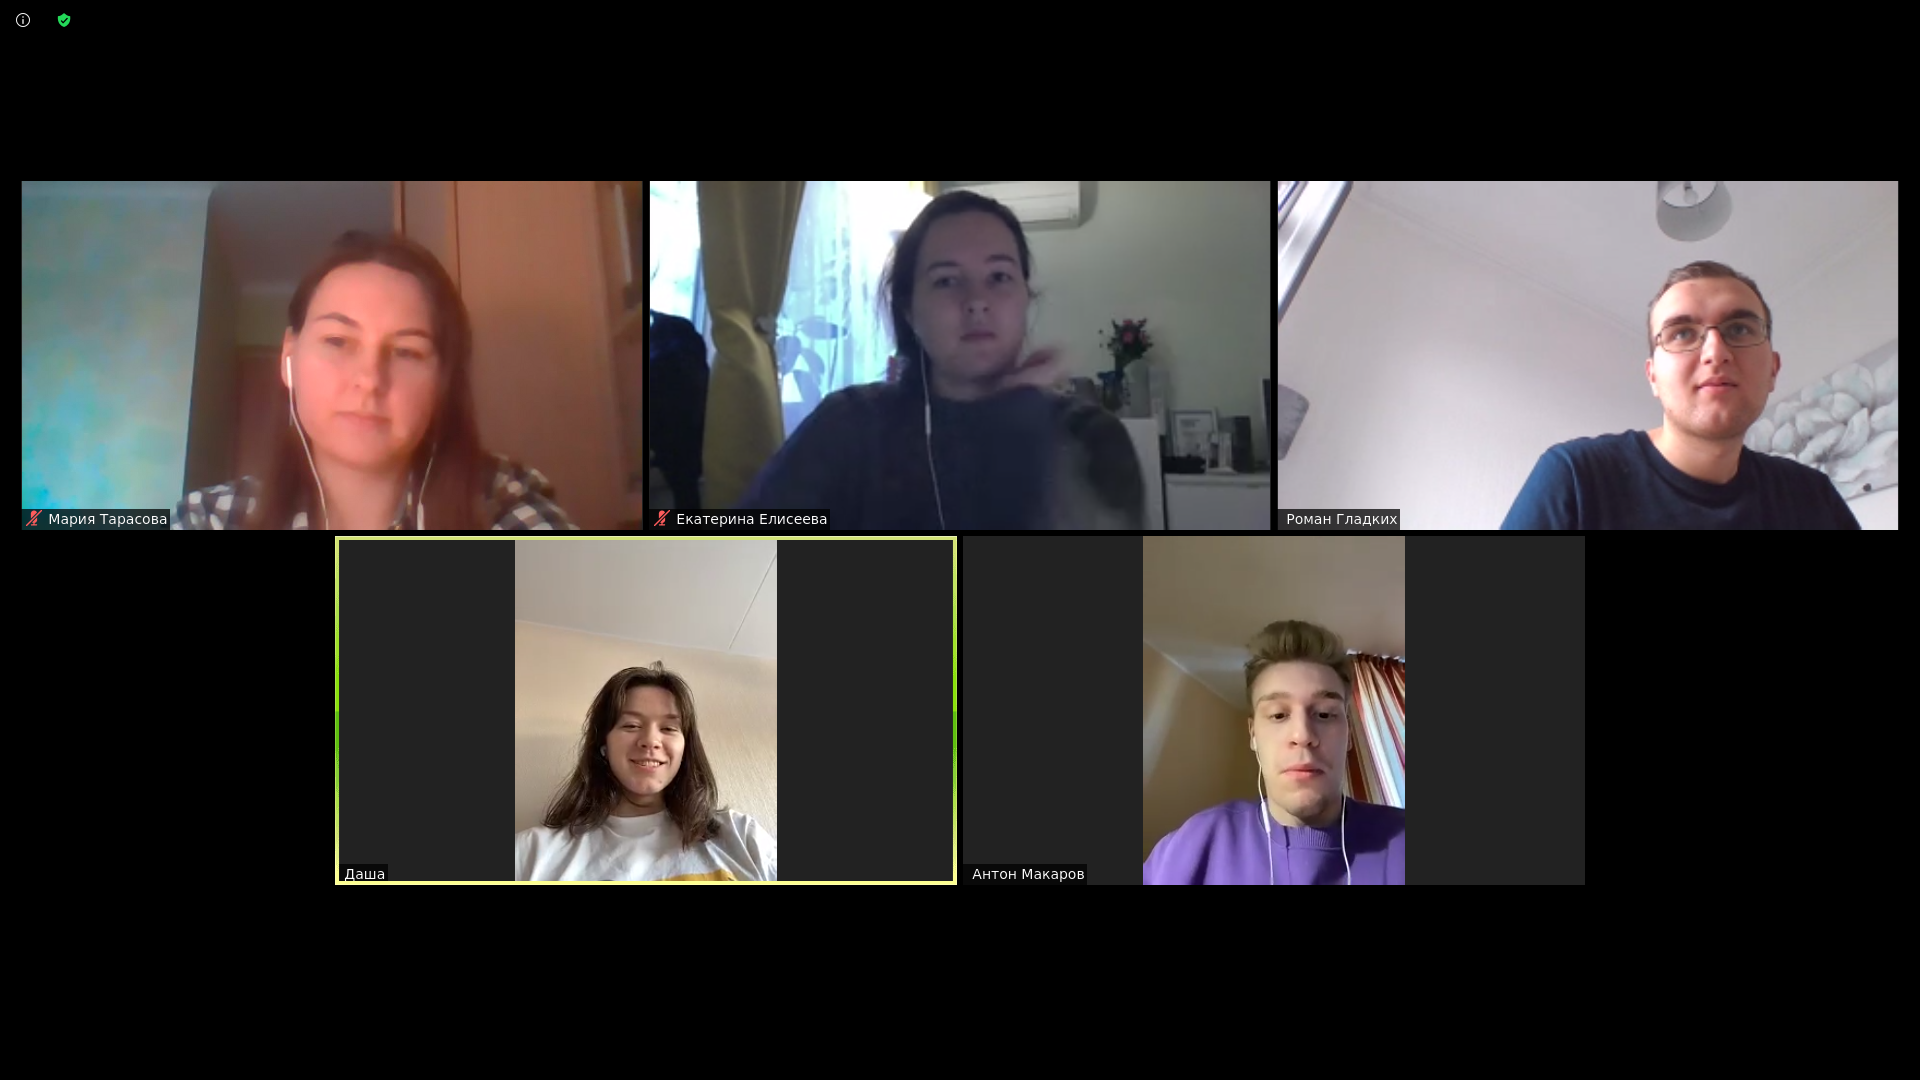